In [1]:
#!pip install tensorflow

In [2]:
#!pip install matplotlib

# Get & Load the MNIST Data

We need a set of real handwritten digits to give the discriminator a starting point in distinguishing between real and fake images. We'll use MNIST, a benchmark dataset in deep learning. It consists of 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students.

In [3]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/MNIST_data/', one_hot = True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /MNIST_data/t10k-labels-idx1-ubyte.gz


# See the Sample Data/Image

The MNIST variable we created above contains both the images and their labels, divided into a training set called train and a validation set called validation. Since GAN is an unsupervised learning, we won't need to worry about the labels here. 


Hint: If you run the cell below again, you'll see a different image from the MNIST training set. TRY IT YOURSELF :)

(1, 784)


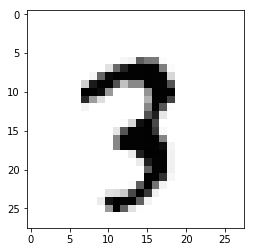

In [4]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')
plt.show()

# Discriminator Network

Our discriminator is a convolutional neural network that takes in an image of size 28 x 28 x 1 as input and returns a single scalar number that describes whether or not the input image is "real" or "fake"—that is, whether it's drawn from the set of MNIST images or generated by the generator.

The structure of our discriminator network is based closely on [TensorFlow's sample CNN classifier model][1]. It features two convolutional layers that find 5x5-pixel features, and two "fully connected" layers that multiply weights by every pixel in the image.
To set up each layer, we start by creating weight and bias variables through *tf.get_variable()*. Weights are initialized from a [truncated normal][2] distribution, and biases are initialized at zero.

*tf.nn.conv2d()* is TensorFlow's standard convolution function. It takes 4 arguments. The first is the input volume (our 28 x 28 x 1 images in this case). The next argument is the filter/weight matrix. Finally, you can also change the stride and padding of the convolution. Those two values affect the dimensions of the output volume.

If you're already comfortable with CNNs, you'll recognize this as a simple binary classifier—nothing fancy.

[1]: https://www.tensorflow.org/get_started/mnist/pros   "TensorFlow's sample CNN classifier model"
[2]: https://www.tensorflow.org/api_docs/python/tf/truncated_normal   "truncated normal"

In [5]:
def discriminator(images, reuse_variables = None):
    with tf.variable_scope(tf.get_variable_scope(), reuse = reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

# Generator Network

Now that we have our discriminator defined, let’s take a look at the generator model. We'll base the overall structure of our model on a simple generator published by [Tim O'Shea][1].

You can think of the generator as a kind of reverse convolutional neural network. A typical CNN like our discriminator network transforms a 2-dim or 3-dim matrix of pixel values into a single probability. 

A generator, however, takes a d-dimensional vector of noise and upsamples it to become a 28 x 28 image. ReLU and batch normalization are used to stabilize the outputs of each layer. In our generator network, we use three convolutional layers along with interpolation until a 28 x 28 pixel image is formed.

At the output layer we add a *tf.sigmoid()* activation function; this squeezes pixels that would appear grey toward either black or white, resulting in a crisper image.

[1]: https://github.com/osh/KerasGAN   "Tim O'Shea"

In [6]:
def generator(z, batch_size, z_dim):
    # from z_dim we defined to 56*56 dimention (detail see the notebook written on 12/15/2017)
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)
    
    # generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])
    
    # generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])
    
    # final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    #output a vector whose dimension is batch_size*28*28*1
    return g4

# Generating a sample image

Yeah! We’ve defined both the generator and discriminator functions. Let’s see what a sample output from an **untrained** generator looks like.

In [7]:
"""see the fake image we generate"""

# Define the plceholder and the graph
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

# For generator, one image for a batch
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

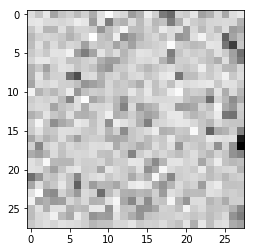

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')
    plt.show()

oooopse!! Why does the above image look like noise? It's untrained!!

# Train a GAN

Now, we need to train the weights and biases in the generator network to convert random numbers into recognizable digits. Let's look at loss functions and optimization!

One of the trickiest parts of building and tuning GANs is that they have two loss functions: 

1. to encourages the generator to create better images
2. to encourages the discriminator to distinguish generated images from real images

We train both the generator and the discriminator simultaneously. As the discriminator gets better at distinguishing real images from generated images, the generator is able to better tune its weights and biases to generate convincing images.

In [9]:
# Gz: fake images, Dx: the score of real image, Dg: the score of the fake image
tf.reset_default_graph()
batch_size = 50

# for feeding input noise to the generator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name = 'z_placeholder')

# for feeding input images to the discriminator
x_placeholder = tf.placeholder(tf.float32, shape = [None, 28, 28, 1], name = 'x_placeholder')

# holds the generated images
Gz = generator(z_placeholder, batch_size, z_dimensions)

# hold discriminator prediction probabilities for the real MNIST images
Dx = discriminator(x_placeholder)

# hold discriminator prediction probabilities for generated images
Dg = discriminator(Gz, reuse_variables=True)

**A. make *discriminator* stronger**

> The discriminator's goal is to correctly label real MNIST images as real (return a higher output) and generated images as fake (return a lower output). We'll calculate two losses for the discriminator:
    
> 1. **goal:** minimize the difference between Dx and 1 for real images from the MNIST set
> 2. **goal:** minimize the difference between Gz and 0 for images from the generator

> **Hint: z \* -log(sigmoid(x)) + (1 - z) \* -log(1 - sigmoid(x)), where x = logits, z = labels**

> We'll do this with TensorFlow's **tf.nn.sigmoid_cross_entropy_with_logits()** function, which calculates the cross-entropy losses between Dx and 1 and between Dg and 0.

> **tf.reduce_mean()** function takes the mean value of all of the components in the matrix returned by the cross entropy function. This is a way of reducing the loss to a single scalar value, instead of a vector or matrix.

**B. make *generator* stronger**

> goal: minimize **the loss between Dg and 1.**

> We want the generator network to create images that will fool the discriminator: the generator wants the discriminator to output a value close to 1 when it's given an image from the generator.


In [10]:
# Two Loss Functions for discriminator
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

# Loss Functions for generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

Hint: **tf.ones_like(x)** & **tf.zeros_like(x)** will return a tensor of the same type and shape as tensor with all elements set to 1 and to 0.

Now that we have our loss functions, we need to define our optimizers. The optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. Likewise, when we train the discriminator, we want to hold the generator's weights fixed.

In order to make this distinction, we need to create two lists of variables, one with the discriminator’s weights and biases and another with the generator’s weights and biases. This is where naming all of your TensorFlow variables with a thoughtful scheme can come in handy.

In [11]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


Next, we specify our two optimizers. [Adam][1] is usually the optimization algorithm of choice for GANs; it utilizes adaptive learning rates and momentum. We call Adam's minimize function and also specify the variables that we want it to update—the generator's weights and biases when we train the generator, and the discriminator's weights and biases when we train the discriminator.
We're setting up two different training operations for the discriminator here: one that trains the discriminator on real images and one that trains the discrmnator on fake images. It's sometimes useful to use different learning rates for these two training operations, or to use them separately to regulate learning in other ways.

We're setting up two different training operations for the discriminator here: 

1. trains the discriminator on real images
2. trains the discrmnator on fake images

It's sometimes useful to use different learning rates for these two training operations, or to use them separately to regulate learning in other ways.

[1]: https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer "Adam"

In [12]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [13]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.693051 dLossFake: 0.717046
dLossReal: 0.0774836 dLossFake: 0.297483
dLossReal: 0.00079955 dLossFake: 0.00269094
dLossReal: 0.000371446 dLossFake: 0.00142302
dLossReal: 0.000266058 dLossFake: 0.000914712
dLossReal: 0.000248506 dLossFake: 0.000646497
dLossReal: 0.000155075 dLossFake: 0.000559775
dLossReal: 0.000142512 dLossFake: 0.000595066
dLossReal: 0.00012581 dLossFake: 0.000398765
dLossReal: 9.16064e-05 dLossFake: 0.000350761
Iteration: 0 at 2018-01-26 09:53:46.805113


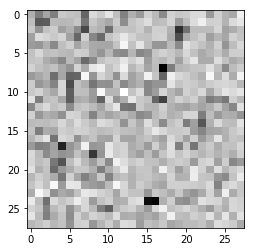

Estimate: [[-8.61684418]]
Iteration: 100 at 2018-01-26 09:54:56.119694


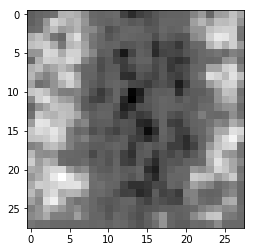

Estimate: [[-7.85726261]]
Iteration: 200 at 2018-01-26 09:56:05.506654


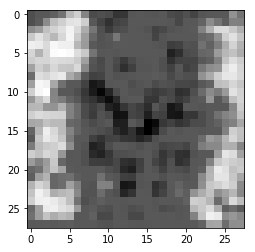

Estimate: [[-11.13520718]]
Iteration: 300 at 2018-01-26 09:57:13.685699


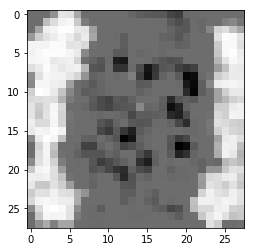

Estimate: [[-15.40500355]]
Iteration: 400 at 2018-01-26 09:58:23.149130


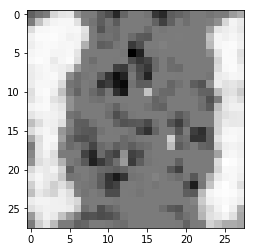

Estimate: [[-12.66050911]]
Iteration: 500 at 2018-01-26 09:59:32.212761


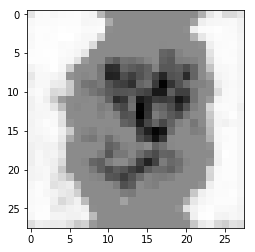

Estimate: [[-20.01177216]]
Iteration: 600 at 2018-01-26 10:00:41.861775


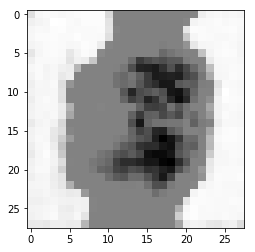

Estimate: [[-14.83164024]]
Iteration: 700 at 2018-01-26 10:01:51.375039


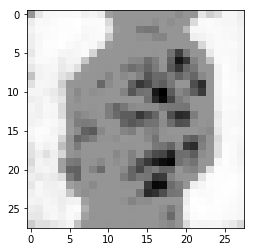

Estimate: [[-15.56256676]]
Iteration: 800 at 2018-01-26 10:03:00.632998


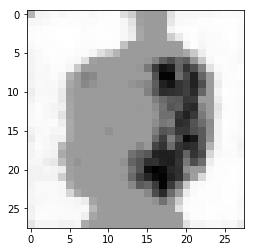

Estimate: [[-13.84245396]]
Iteration: 900 at 2018-01-26 10:04:09.488392


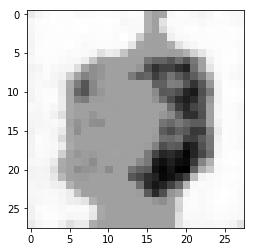

Estimate: [[-12.13381386]]
Iteration: 1000 at 2018-01-26 10:05:18.702469


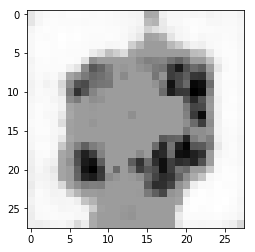

Estimate: [[-10.62666225]]
Iteration: 1100 at 2018-01-26 10:06:28.070607


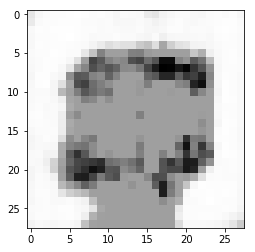

Estimate: [[-27.33337784]]
Iteration: 1200 at 2018-01-26 10:07:36.822139


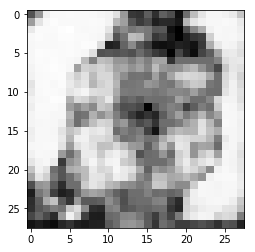

Estimate: [[-9.01100922]]
Iteration: 1300 at 2018-01-26 10:08:45.910596


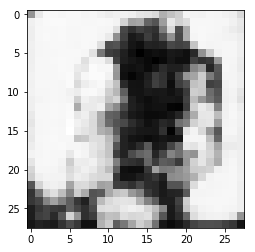

Estimate: [[-8.32645416]]
Iteration: 1400 at 2018-01-26 10:09:54.556070


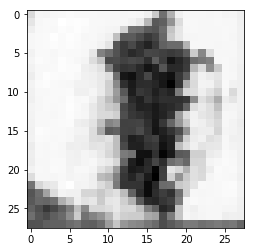

Estimate: [[-7.27517462]]
Iteration: 1500 at 2018-01-26 10:11:03.311414


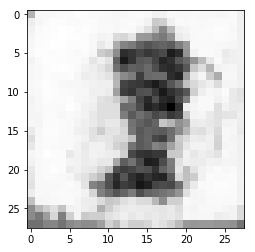

Estimate: [[-7.81265593]]
Iteration: 1600 at 2018-01-26 10:12:12.522614


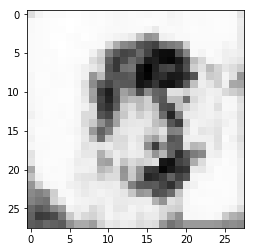

Estimate: [[-7.06010675]]
Iteration: 1700 at 2018-01-26 10:13:21.228869


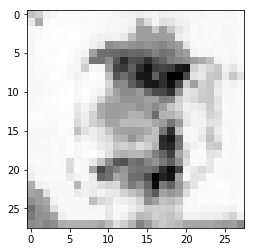

Estimate: [[-9.50070572]]
Iteration: 1800 at 2018-01-26 10:14:30.480392


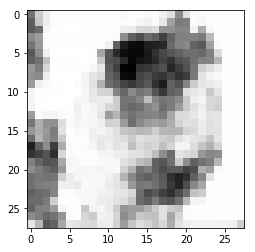

Estimate: [[-12.52099037]]
Iteration: 1900 at 2018-01-26 10:15:39.266889


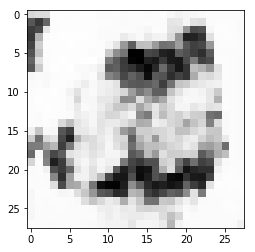

Estimate: [[-9.90932083]]
Iteration: 2000 at 2018-01-26 10:16:48.925153


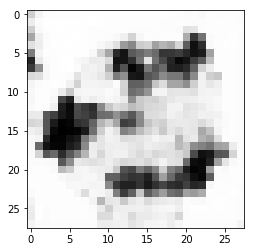

Estimate: [[-7.89121342]]
Iteration: 2100 at 2018-01-26 10:17:58.321223


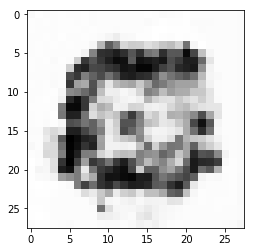

Estimate: [[-7.28694725]]
Iteration: 2200 at 2018-01-26 10:19:07.421838


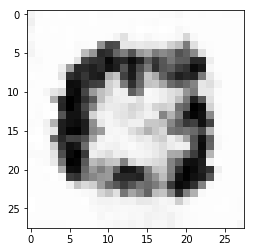

Estimate: [[-6.68000603]]
Iteration: 2300 at 2018-01-26 10:20:17.150701


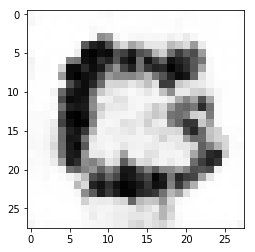

Estimate: [[-10.66688538]]
Iteration: 2400 at 2018-01-26 10:21:25.453489


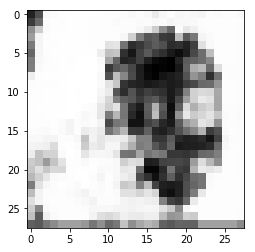

Estimate: [[-8.62673378]]
Iteration: 2500 at 2018-01-26 10:22:34.555137


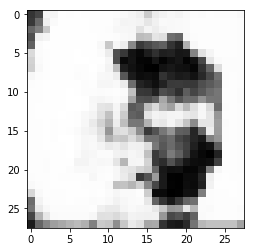

Estimate: [[-9.52117443]]
Iteration: 2600 at 2018-01-26 10:23:42.929046


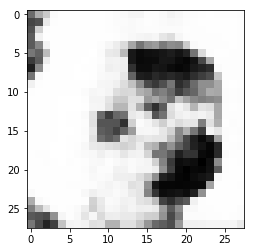

Estimate: [[-8.87181091]]
Iteration: 2700 at 2018-01-26 10:24:52.514036


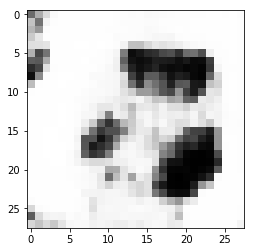

Estimate: [[-8.28657341]]
Iteration: 2800 at 2018-01-26 10:26:01.669125


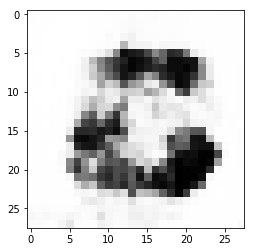

Estimate: [[-6.01874352]]
Iteration: 2900 at 2018-01-26 10:27:10.178766


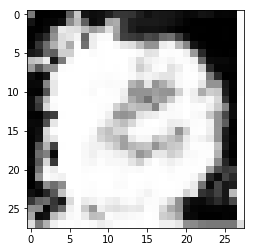

Estimate: [[-13.00730324]]
Iteration: 3000 at 2018-01-26 10:28:19.624231


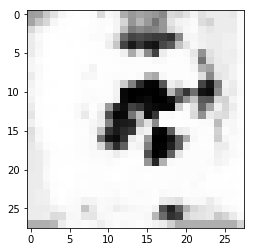

Estimate: [[-18.54145241]]
Iteration: 5000 at 2018-01-26 10:51:33.455905


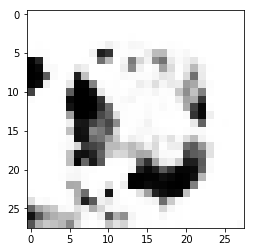

Estimate: [[-26.30840683]]
Iteration: 5100 at 2018-01-26 10:52:43.173870


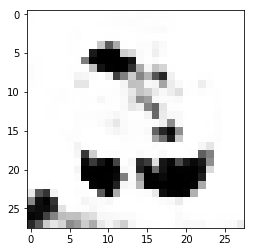

Estimate: [[-39.3185463]]
Iteration: 5200 at 2018-01-26 10:53:52.608368


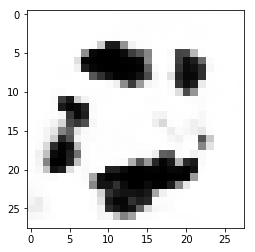

Estimate: [[-47.30369949]]
Iteration: 5300 at 2018-01-26 10:55:02.507389


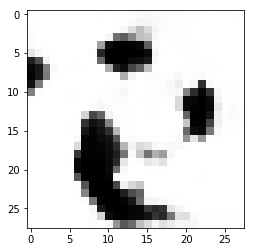

Estimate: [[-30.56353378]]
Iteration: 5400 at 2018-01-26 10:56:12.164045


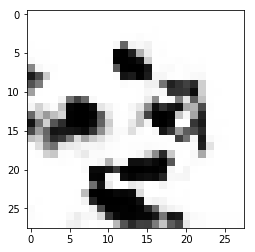

Estimate: [[-56.21606827]]
Iteration: 5500 at 2018-01-26 10:57:21.319711


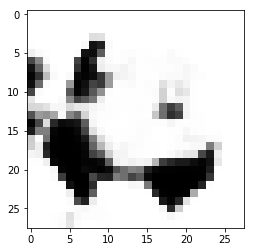

Estimate: [[-136.7928009]]
Iteration: 5600 at 2018-01-26 10:58:30.967860


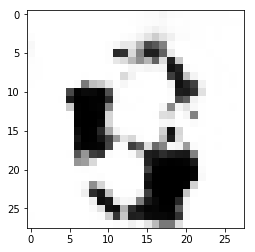

Estimate: [[-66.94179535]]
Iteration: 5700 at 2018-01-26 10:59:40.107053


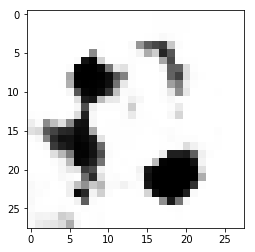

Estimate: [[-38.36747742]]
Iteration: 5800 at 2018-01-26 11:00:49.918043


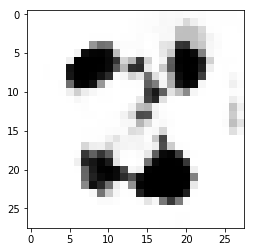

Estimate: [[-63.79922867]]
Iteration: 5900 at 2018-01-26 11:01:58.340222


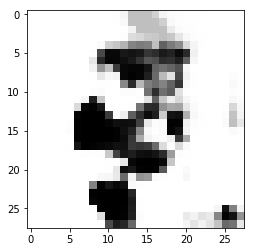

Estimate: [[-16.64395714]]
Iteration: 6000 at 2018-01-26 11:03:07.647607


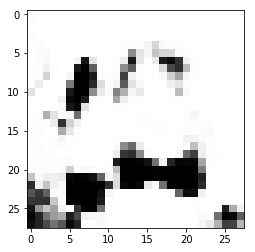

Estimate: [[-52.34753036]]
Iteration: 6100 at 2018-01-26 11:04:17.490866


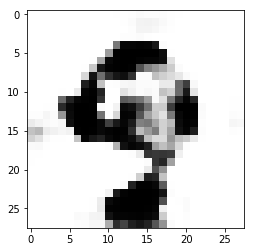

Estimate: [[-43.56151962]]
Iteration: 6200 at 2018-01-26 11:05:26.801525


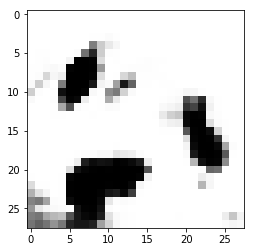

Estimate: [[-31.5477562]]
Iteration: 6300 at 2018-01-26 11:06:36.028753


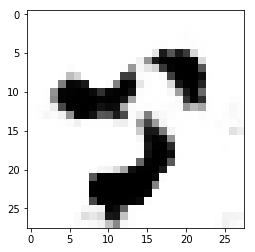

Estimate: [[-22.85188293]]
Iteration: 6400 at 2018-01-26 11:07:44.774057


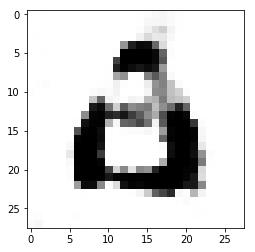

Estimate: [[-11.90716457]]
Iteration: 6500 at 2018-01-26 11:08:54.300980


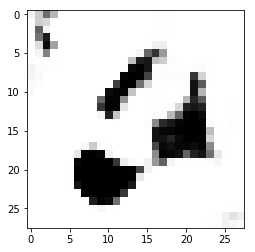

Estimate: [[-30.82132912]]
Iteration: 6600 at 2018-01-26 11:10:03.518139


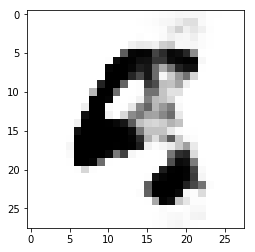

Estimate: [[-27.89216995]]
Iteration: 6700 at 2018-01-26 11:11:12.847835


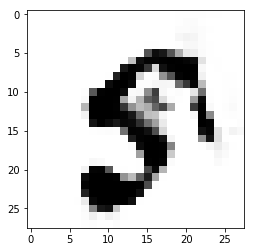

Estimate: [[-17.84015846]]
Iteration: 6800 at 2018-01-26 11:12:22.407180


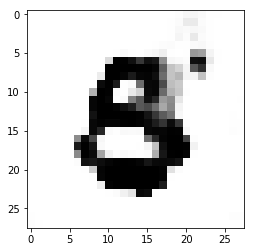

Estimate: [[-17.24603844]]
Iteration: 6900 at 2018-01-26 11:13:31.873071


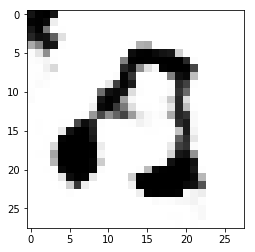

Estimate: [[-35.39770889]]
Iteration: 7000 at 2018-01-26 11:14:41.652987


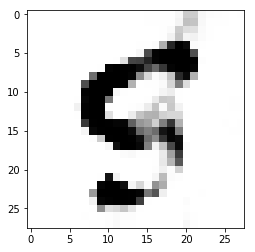

Estimate: [[-6.19202042]]
Iteration: 7100 at 2018-01-26 11:15:50.282087


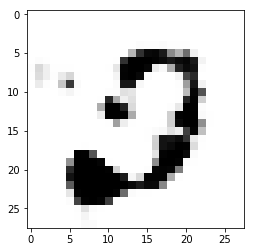

Estimate: [[-32.31240082]]
Iteration: 7200 at 2018-01-26 11:16:59.943718


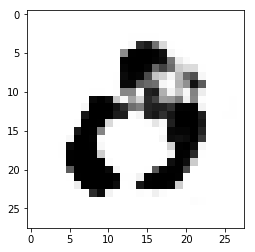

Estimate: [[-14.34555626]]
Iteration: 7300 at 2018-01-26 11:18:09.574225


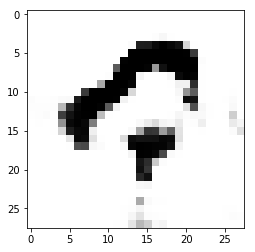

Estimate: [[-12.59370136]]
Iteration: 7400 at 2018-01-26 11:19:18.646009


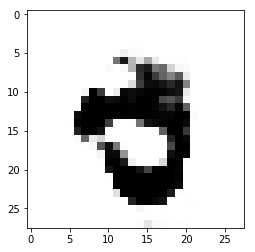

Estimate: [[-40.59929657]]
Iteration: 7500 at 2018-01-26 11:20:27.725417


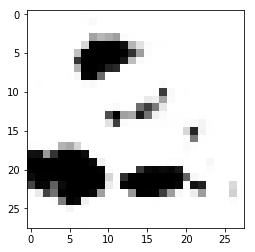

Estimate: [[-16.89021492]]
Iteration: 7600 at 2018-01-26 11:21:37.323241


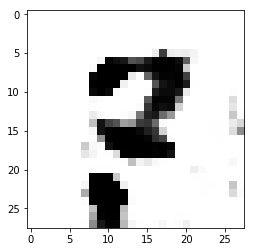

Estimate: [[-39.15629196]]
Iteration: 7700 at 2018-01-26 11:22:47.067189


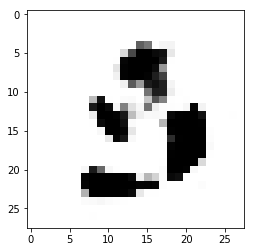

Estimate: [[-46.59072495]]
Iteration: 7800 at 2018-01-26 11:23:56.678304


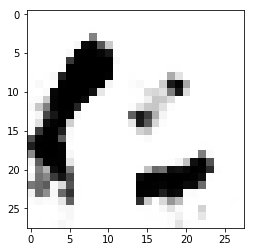

Estimate: [[-42.15953064]]
Iteration: 7900 at 2018-01-26 11:25:05.932276


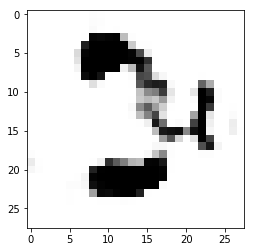

Estimate: [[-28.93322945]]
Iteration: 8000 at 2018-01-26 11:26:16.129495


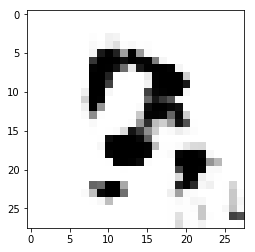

Estimate: [[-41.50430298]]
Iteration: 8100 at 2018-01-26 11:27:25.603991


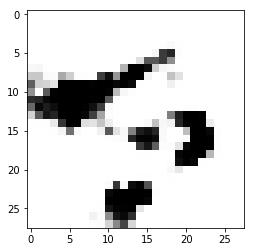

Estimate: [[-15.29514217]]
Iteration: 8200 at 2018-01-26 11:28:35.612004


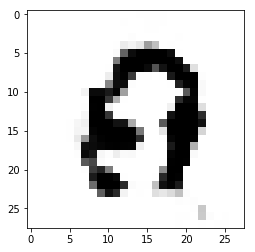

Estimate: [[-24.07993698]]
Iteration: 8300 at 2018-01-26 11:29:45.060575


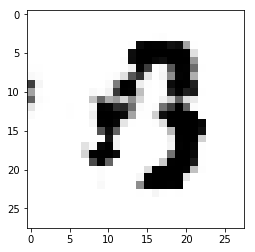

Estimate: [[-17.35618782]]
Iteration: 8400 at 2018-01-26 11:30:54.803619


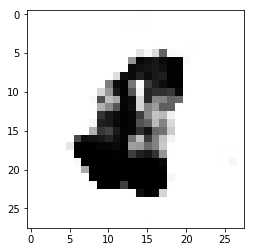

Estimate: [[-32.79484558]]
Iteration: 8500 at 2018-01-26 11:32:03.528338


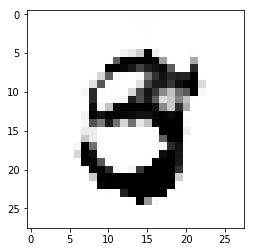

Estimate: [[-33.75483704]]
Iteration: 8600 at 2018-01-26 11:33:13.009595


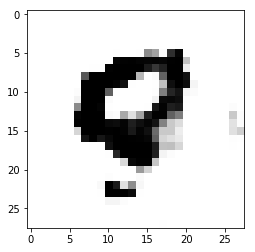

Estimate: [[-9.38391876]]
Iteration: 8700 at 2018-01-26 11:34:22.842208


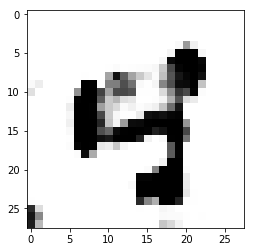

Estimate: [[-40.07377625]]
Iteration: 8800 at 2018-01-26 11:35:32.169282


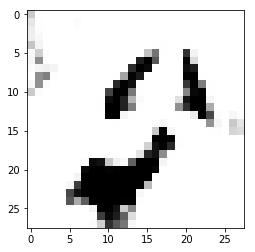

Estimate: [[-57.84328461]]
Iteration: 8900 at 2018-01-26 11:36:41.596122


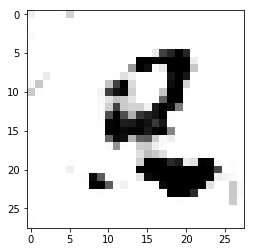

Estimate: [[-14.55069733]]
Iteration: 9000 at 2018-01-26 11:37:50.689082


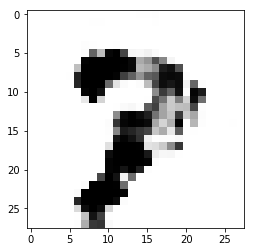

Estimate: [[-51.22405624]]
Iteration: 9100 at 2018-01-26 11:38:59.904299


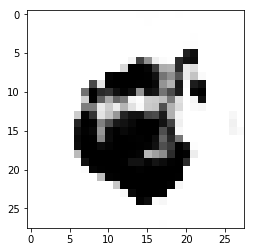

Estimate: [[ 3.5991888]]
Iteration: 9200 at 2018-01-26 11:40:10.028397


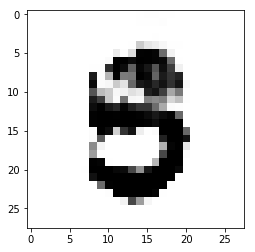

Estimate: [[-35.41980362]]
Iteration: 9300 at 2018-01-26 11:41:19.714597


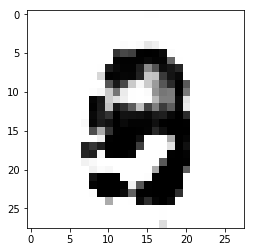

Estimate: [[-6.0811758]]
Iteration: 9400 at 2018-01-26 11:42:29.416257


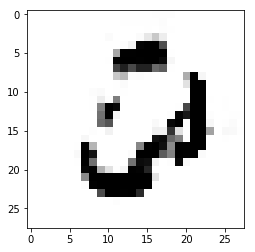

Estimate: [[-33.60137939]]
Iteration: 9500 at 2018-01-26 11:43:38.676722


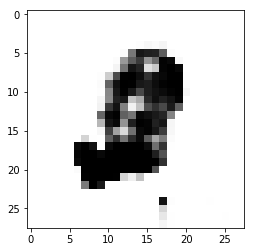

Estimate: [[-10.44116688]]
Iteration: 9600 at 2018-01-26 11:44:48.467068


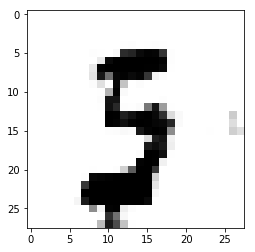

Estimate: [[-29.05734825]]
Iteration: 9700 at 2018-01-26 11:45:57.558971


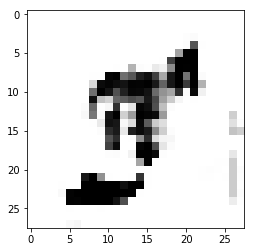

Estimate: [[-28.17750931]]
Iteration: 9800 at 2018-01-26 11:47:07.597150


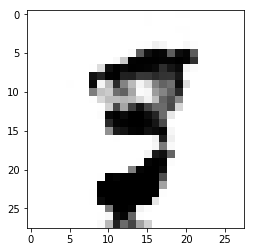

Estimate: [[-17.44804573]]
Iteration: 9900 at 2018-01-26 11:48:16.590149


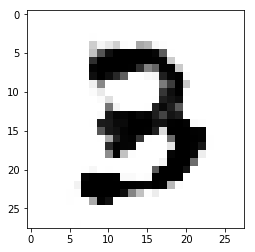

Estimate: [[-42.52866364]]
Iteration: 10000 at 2018-01-26 11:49:26.584593


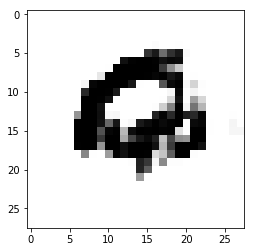

Estimate: [[-29.52654076]]
Iteration: 10100 at 2018-01-26 11:50:36.310618


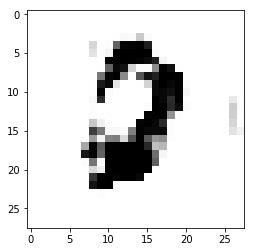

Estimate: [[-28.00640106]]
Iteration: 10200 at 2018-01-26 11:51:45.988437


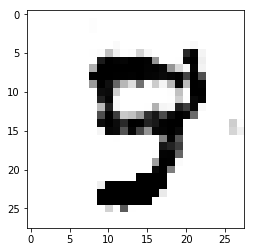

Estimate: [[-8.95676231]]
Iteration: 10300 at 2018-01-26 11:52:55.552017


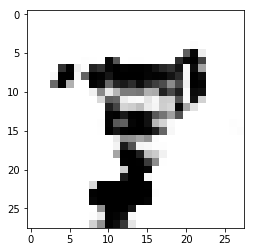

Estimate: [[-28.06384468]]
Iteration: 10400 at 2018-01-26 11:54:05.267912


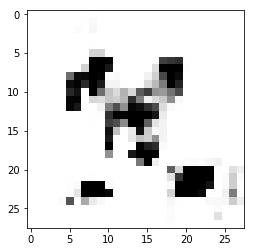

Estimate: [[-40.44496918]]
Iteration: 10500 at 2018-01-26 11:55:14.612348


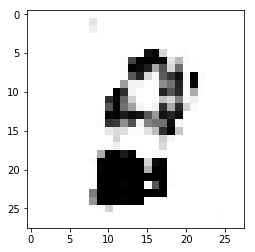

Estimate: [[-70.13214874]]
Iteration: 10600 at 2018-01-26 11:56:24.468218


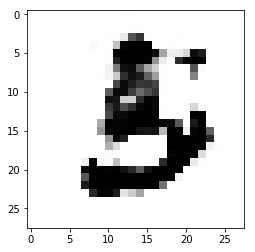

Estimate: [[ 13.89862728]]
Iteration: 10700 at 2018-01-26 11:57:33.847423


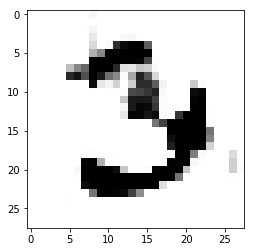

Estimate: [[ 7.30242491]]
Iteration: 10800 at 2018-01-26 11:58:43.319024


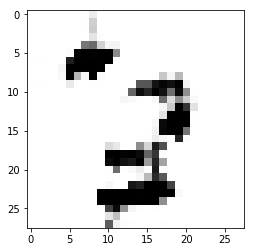

Estimate: [[-35.93695831]]
Iteration: 10900 at 2018-01-26 11:59:53.309058


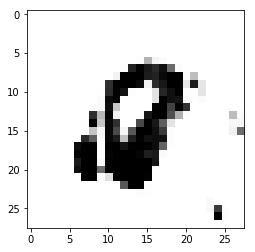

Estimate: [[-9.473629]]
Iteration: 11000 at 2018-01-26 12:01:02.842160


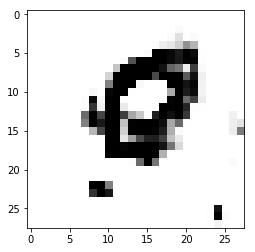

Estimate: [[-27.95047379]]
Iteration: 11100 at 2018-01-26 12:02:11.589785


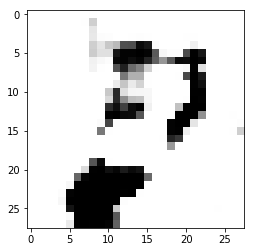

Estimate: [[-0.65112478]]
Iteration: 11200 at 2018-01-26 12:03:20.539129


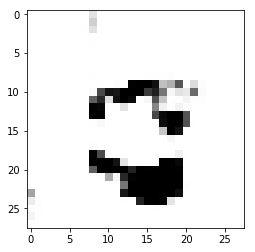

Estimate: [[-21.83733749]]
Iteration: 11300 at 2018-01-26 12:04:30.157147


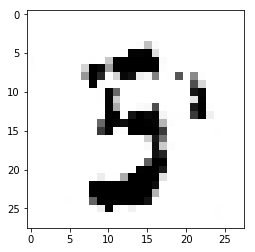

Estimate: [[-46.65571976]]
Iteration: 11400 at 2018-01-26 12:05:39.518899


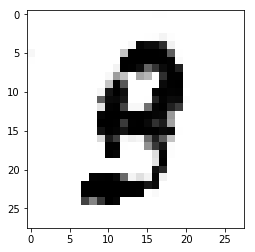

Estimate: [[-36.51026535]]
Iteration: 11500 at 2018-01-26 12:06:49.449292


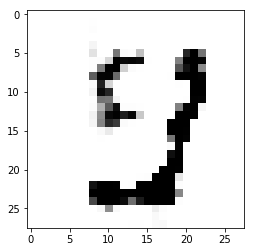

Estimate: [[-43.75396347]]
Iteration: 11600 at 2018-01-26 12:07:58.911313


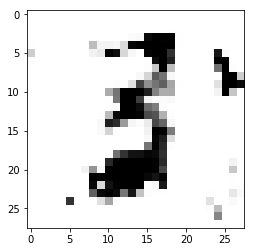

Estimate: [[-53.24892807]]
Iteration: 11700 at 2018-01-26 12:09:08.467255


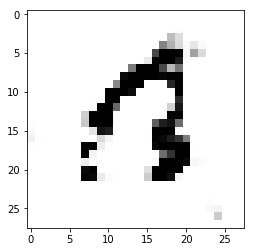

Estimate: [[-72.679245]]
Iteration: 11800 at 2018-01-26 12:10:18.276321


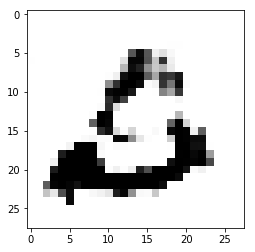

Estimate: [[-29.53293228]]
Iteration: 11900 at 2018-01-26 12:11:27.512800


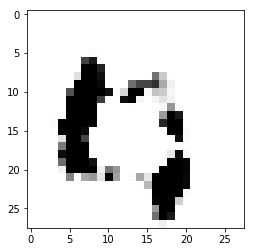

Estimate: [[ 51.91868973]]
Iteration: 12000 at 2018-01-26 12:12:37.331671


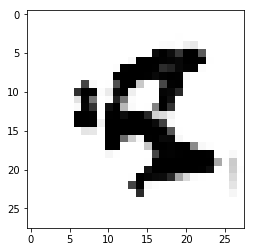

Estimate: [[-23.32226372]]
Iteration: 12100 at 2018-01-26 12:13:46.739841


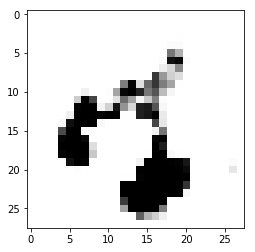

Estimate: [[-39.89504242]]
Iteration: 12200 at 2018-01-26 12:14:56.741321


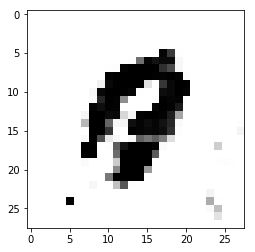

Estimate: [[-26.38615799]]
Iteration: 12300 at 2018-01-26 12:16:05.891274


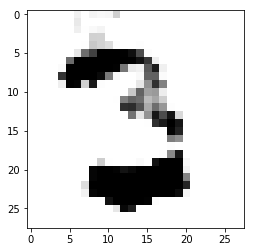

Estimate: [[-42.38622284]]
Iteration: 12400 at 2018-01-26 12:17:15.048992


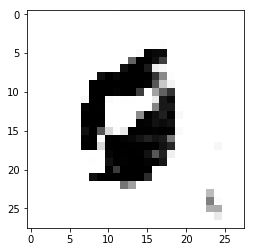

Estimate: [[-8.11174393]]
Iteration: 12500 at 2018-01-26 12:18:24.791300


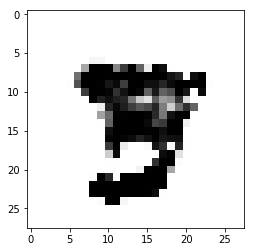

Estimate: [[-56.00782776]]
Iteration: 12600 at 2018-01-26 12:19:33.954324


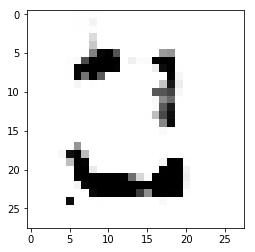

Estimate: [[-20.30490685]]
Iteration: 12700 at 2018-01-26 12:20:43.620894


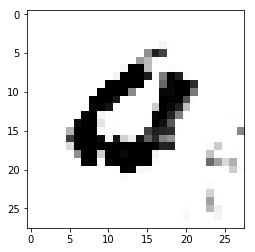

Estimate: [[-2.17675328]]
Iteration: 12800 at 2018-01-26 12:21:53.459663


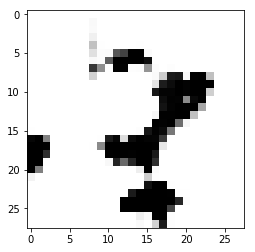

Estimate: [[-31.22502518]]
Iteration: 12900 at 2018-01-26 12:23:02.610174


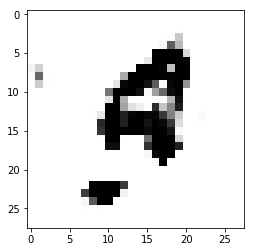

Estimate: [[-68.63342285]]
Iteration: 13000 at 2018-01-26 12:24:12.169504


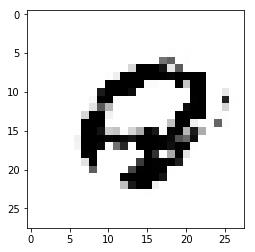

Estimate: [[-12.64882183]]
Iteration: 13100 at 2018-01-26 12:25:21.539459


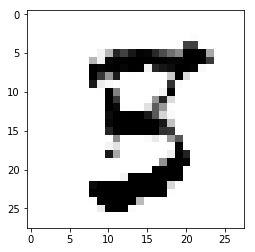

Estimate: [[-37.01166916]]
Iteration: 13200 at 2018-01-26 12:26:31.784217


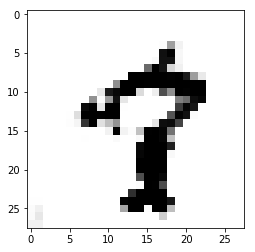

Estimate: [[-11.01277256]]
Iteration: 13300 at 2018-01-26 12:27:41.504556


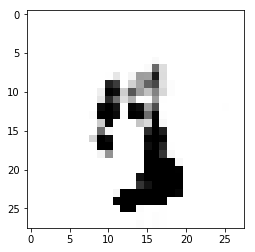

Estimate: [[-2.1550014]]
Iteration: 13400 at 2018-01-26 12:28:51.149905


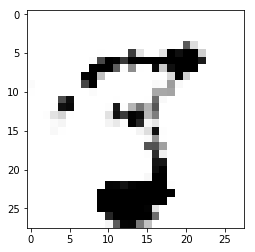

Estimate: [[-18.23623466]]
Iteration: 13500 at 2018-01-26 12:30:00.219274


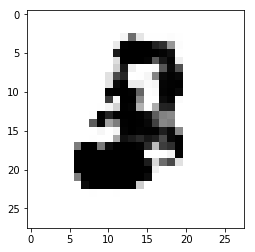

Estimate: [[ 6.52592802]]
Iteration: 13600 at 2018-01-26 12:31:09.544195


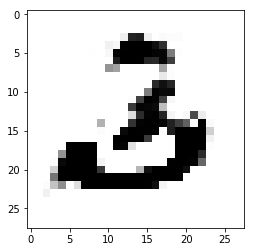

Estimate: [[-30.28634834]]
Iteration: 13700 at 2018-01-26 12:32:19.466287


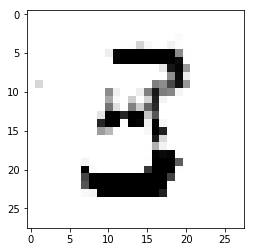

Estimate: [[-6.69454908]]
Iteration: 13800 at 2018-01-26 12:33:29.067561


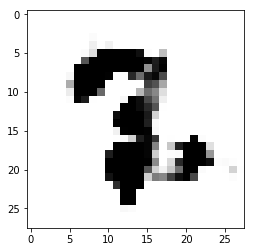

Estimate: [[ 1.00922167]]
Iteration: 13900 at 2018-01-26 12:34:38.616804


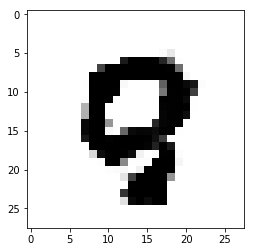

Estimate: [[-7.1380806]]
Iteration: 14000 at 2018-01-26 12:35:48.409996


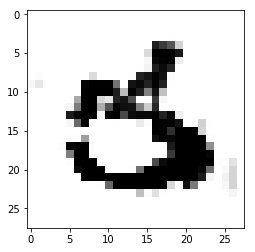

Estimate: [[-40.18711472]]
Iteration: 14100 at 2018-01-26 12:36:57.966296


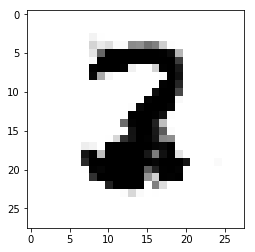

Estimate: [[-60.28125]]
Iteration: 14200 at 2018-01-26 12:38:07.709192


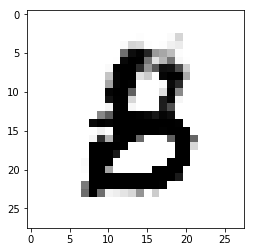

Estimate: [[-42.11294937]]
Iteration: 14300 at 2018-01-26 12:39:16.885611


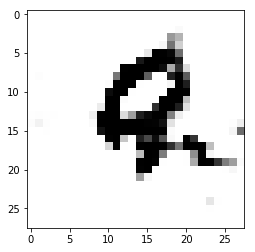

Estimate: [[-40.71358109]]
Iteration: 14400 at 2018-01-26 12:40:26.614126


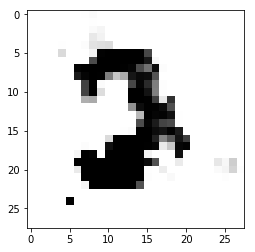

Estimate: [[ 12.30038261]]
Iteration: 14500 at 2018-01-26 12:41:36.334308


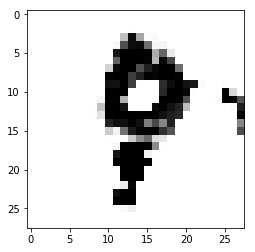

Estimate: [[ 16.67947006]]
Iteration: 14600 at 2018-01-26 12:42:46.079665


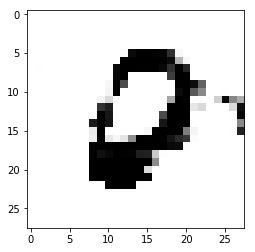

Estimate: [[-19.83140945]]
Iteration: 14700 at 2018-01-26 12:43:56.107024


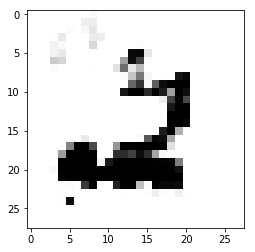

Estimate: [[-23.58554077]]
Iteration: 14800 at 2018-01-26 12:45:05.707553


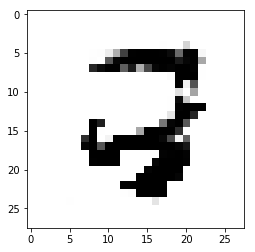

Estimate: [[-46.43650436]]
Iteration: 14900 at 2018-01-26 12:46:15.985091


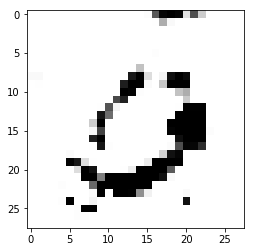

Estimate: [[-1.61235702]]
Iteration: 15000 at 2018-01-26 12:47:25.743906


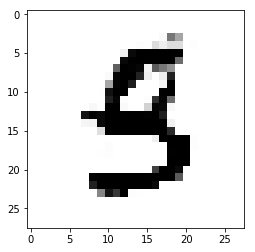

Estimate: [[-53.32141113]]
Iteration: 15100 at 2018-01-26 12:48:35.473241


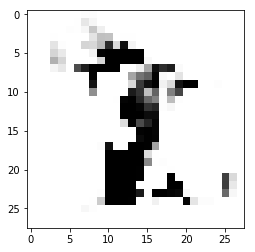

Estimate: [[-6.33031416]]
Iteration: 15200 at 2018-01-26 12:49:44.910304


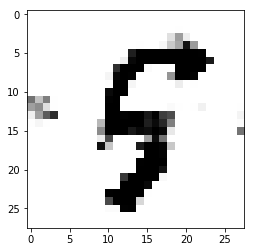

Estimate: [[-13.37895679]]
Iteration: 15300 at 2018-01-26 12:50:54.581191


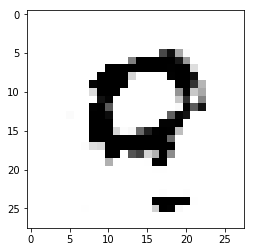

Estimate: [[-11.10793018]]
Iteration: 15400 at 2018-01-26 12:52:04.842967


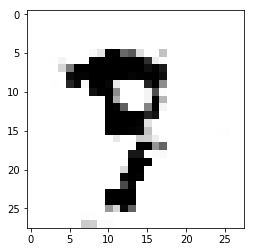

Estimate: [[ 7.91040564]]
Iteration: 15500 at 2018-01-26 12:53:14.453267


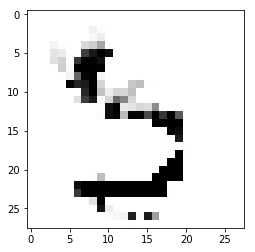

Estimate: [[ 12.5000248]]
Iteration: 15600 at 2018-01-26 12:54:23.965420


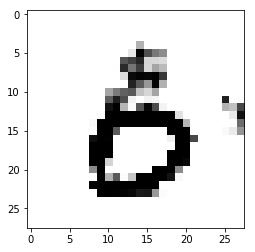

Estimate: [[ 17.87789917]]
Iteration: 15700 at 2018-01-26 12:55:33.665562


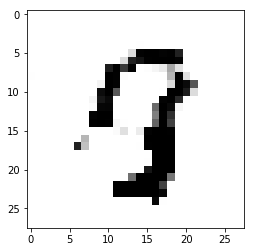

Estimate: [[-71.82286072]]
Iteration: 15800 at 2018-01-26 12:56:43.875645


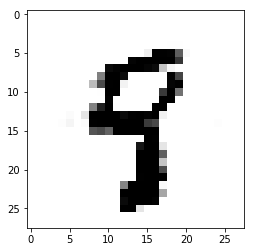

Estimate: [[ 10.72335434]]
Iteration: 15900 at 2018-01-26 12:57:54.456857


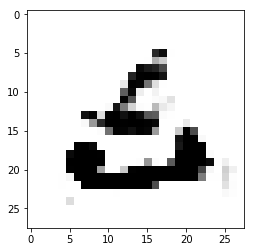

Estimate: [[-27.99225044]]
Iteration: 16000 at 2018-01-26 12:59:04.566371


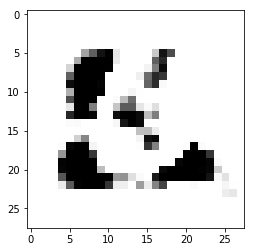

Estimate: [[-48.80531311]]
Iteration: 16100 at 2018-01-26 13:00:14.965402


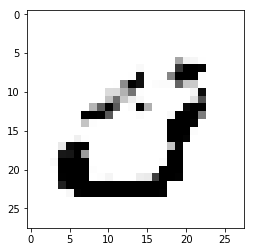

Estimate: [[-22.37169075]]
Iteration: 16200 at 2018-01-26 13:01:25.161458


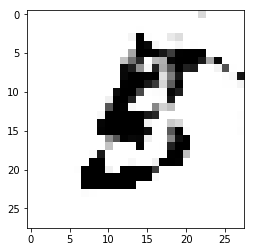

Estimate: [[-67.81873322]]


In [ ]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

#sess = tf.Session()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Pre-train discriminator
    for i in range(1000):
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

        if(i % 100 == 0):
            print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

    # Train generator and discriminator together
    for i in range(1000000):
        real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

        # Train discriminator on both real and fake images
        _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                               {x_placeholder: real_image_batch, z_placeholder: z_batch})

        # Train generator
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

        if i % 10 == 0:
            # Update TensorBoard with summary statistics
            z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
            summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
            writer.add_summary(summary, i)

        if i % 100 == 0:
            # Every 100 iterations, show a generated image
            print("Iteration:", i, "at", datetime.datetime.now())
            z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
            generated_images = generator(z_placeholder, 1, z_dimensions)
            images = sess.run(generated_images, {z_placeholder: z_batch})
            plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
            plt.show()

            # Show discriminator's estimate
            im = images[0].reshape([1, 28, 28, 1])
            result = discriminator(x_placeholder)
            estimate = sess.run(result, {x_placeholder: im})
            print("Estimate:", estimate)
    
    # Save the variables to disk.
    save_path = saver.save(sess, './20180110/GAN20180110-1000000.ckpt')
    print("Model saved in file: %s" % save_path)

In [ ]:
# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "./20180110/GAN20180110-1000000.ckpt")
    print("Model restored.")
    print("all values %s" % sess.run(tf.global_variables()))
    print("v2 value : %s" % sess.run(v2))